In [1]:
import torch
import torch.nn as nn 

In [ ]:
#@@@@@ Overview of the model architecture @@@@@ 

class DummyGPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb    = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb    = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb   = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"] , cfg["vocab_size"],bias=False)
        
        
    def forward(self,in_idx) : ## in_idx is the tokenized input of shape [batch_size , seq_len]
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits

class DummyLayerNorm(nn.Module):
    def __init__(self,cfg):
        super().__init__()
    def forward(self,x):
        return x

class DummyTransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
    def forward(self,x):
        return x
        

In [3]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch_test = []
text1 = "Every effort moves you"
text2 = "Every day holds a"
batch_test.append(torch.tensor(tokenizer.encode(text1)))
batch_test.append(torch.tensor(tokenizer.encode(text2)))
batch_test = torch.stack(batch_test,dim=0)
print(batch_test)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [4]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length ==> after 1024 tokens the model can predict the next token 
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch_test)
print(f"output shape (batch_size , seq_len , vocab_size): ", logits.shape)
print(logits)

output shape (batch_size , seq_len , vocab_size):  torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [5]:
## Layer Normalization , it consists on normalizing the output of a given layer (previous layer)
## making the distribution of the overall output of the activations (Neurons) ~ N(0,1) ==> Stabilizing the training
torch.manual_seed(193)
batch_example = torch.rand(2,5)
layer = nn.Sequential(nn.Linear(5,6),nn.ReLU())
out   = layer(batch_example)
print(out) 
print(f"\nbbefore layer normalization\n")
mean = out.mean(dim=-1,keepdim=True)
var  = out.var(dim=-1,keepdim=True)
print(f"mean ",out.mean(dim=-1,keepdim=True))
print(f"var ",out.var(dim=-1,keepdim=True))

tensor([[0.3710, 0.0000, 0.5695, 0.6726, 0.2738, 0.6135],
        [0.3424, 0.0000, 0.2633, 0.3311, 0.2569, 0.2686]],
       grad_fn=<ReluBackward0>)

bbefore layer normalization

mean  tensor([[0.4167],
        [0.2437]], grad_fn=<MeanBackward1>)
var  tensor([[0.0647],
        [0.0156]], grad_fn=<VarBackward0>)


In [6]:
torch.set_printoptions(sci_mode=False)

out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1,keepdim=True)
var = out_norm.var(dim=-1,keepdim=True)
print(f"\nafter normalization\n")
print(out_norm)
print(f"mean {mean}")
print(f"var {var}")


after normalization

tensor([[-0.1796, -1.6379,  0.6002,  1.0056, -0.5616,  0.7734],
        [ 0.7907, -1.9519,  0.1565,  0.6997,  0.1053,  0.1996]],
       grad_fn=<DivBackward0>)
mean tensor([[     0.0000],
        [    -0.0000]], grad_fn=<MeanBackward1>)
var tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [7]:
## building the layer normalization class 
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5 ## since we are dividing by the square root of the variance , we use eps to prevent division by zero 
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        ## scale and shift are learned parameters that the model can update if this can enhance the training
    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        var = x.var(dim=-1,keepdim=True,unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [8]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1,keepdim=True)
var = out_ln.var(dim=-1,keepdim=True,unbiased=False)
print(f"Mean\n {mean}")
print(f"Variance\n {var}")

Mean
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance
 tensor([[0.9996],
        [0.9999]], grad_fn=<VarBackward0>)


In [9]:
"""    
GELU function is known by its smoothness , as for for ReLU , that turn any negative value into zero
making any neuron with negative output unable to contribute to the training , GELU can acccept a small range of negative values 
allowing to more neurons to contribute in the training process. 
"""
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return 0.5*x*(1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))))


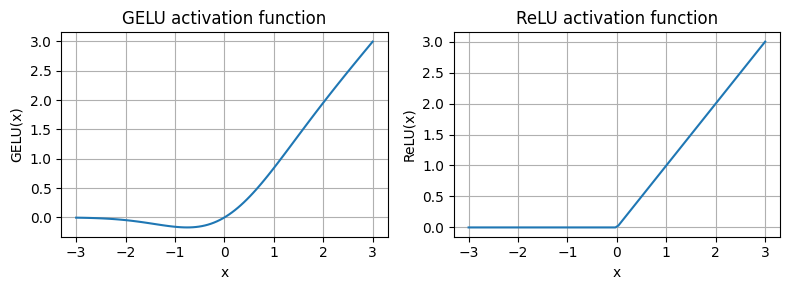

In [10]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
"""
    Feed forward Layer helps the model to learn and generalize data with the conservation of the its shape and reducing complexity 
    of the neural network , it passes temporerly to a higher dimension in order to explore data in a much bigger space and learn more advanced features
    than it returns it to the original shape after passing it through GELU activation function
"""
class FeedForward(nn.Module): 
    def __init__(self,cfg) : 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"] , 4*cfg["emb_dim"]),
            GELU(),
            nn.Linear(4*cfg["emb_dim"] , cfg["emb_dim"])
        )
    def forward(self,x):
        return self.layers(x)

In [12]:
ffn = FeedForward(GPT_CONFIG_124M)
batch = torch.randn([2,3,768])
out = ffn(batch)
print(out.shape)

torch.Size([2, 3, 768])


In [13]:
""" 
    the residual (skip or even shortcut) connection is a method used for preventing Gradient Vanishing in the neural network (so to stabilize the training)
    in fact , gradient may not get to the early layers , so updates in early layers are very small and can't learn during training as the later layers 
    skip connection is a way of creating a short path for the gradients to reach out early layers by skipping some intermediate layers to prevent vanishing.
    it is done by connecting the input of an early layer with the output of more advanced layer
"""

class exampleDeepNN(nn.Module):
    def __init__(self,layer_sizes,use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layer_sizes  = layer_sizes
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0] , layer_sizes[1]) , GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1] , layer_sizes[2]) , GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2] , layer_sizes[3]) , GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3] , layer_sizes[4]) , GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4] , layer_sizes[5]) , GELU())
        ])
    
    def forward(self,x) : 
        for layer in self.layers : 
            layer_out = layer(x)
            if self.use_shortcut and x.shape == layer_out.shape : 
                x = x + layer_out
            else : 
                x = layer_out
        return x 

In [14]:
layers_sizes = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
DNN_without_shortcuts = exampleDeepNN(layers_sizes , use_shortcut=False)
def print_gradients(model,x):
    out = model(x)
    target = torch.tensor([0.])
    loss = nn.MSELoss()
    loss = loss(out , target)
    loss.backward()
    for name , param in model.named_parameters():
        if "weight" in name : 
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")   

In [15]:
print_gradients(DNN_without_shortcuts , sample_input)
## early layers 

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


c:\Users\DHIA\anaconda3\envs\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
DNN_with_shortcuts = exampleDeepNN(layers_sizes , use_shortcut=True)
print_gradients(DNN_with_shortcuts , sample_input)
## the gradient values stabilizes when we progress to the early layers  

layers.0.0.weight has gradient mean of 0.0014432319439947605
layers.1.0.weight has gradient mean of 0.004846962168812752
layers.2.0.weight has gradient mean of 0.0041389018297195435
layers.3.0.weight has gradient mean of 0.00591512955725193
layers.4.0.weight has gradient mean of 0.03265950828790665


In [17]:
from torch.nn import functional as F
class MultiHeadAttention(nn.Module) : 
    def __init__(self,d_in,d_out,context_length,dropout,num_heads,bias=False):
        super().__init__()
        assert(d_out % num_heads ==0 ) ,"d_out must be divisible by num_heads"
        
        self.d_out = d_out
        self.num_heads = num_heads
        
        self.head_dim = d_out // num_heads
        
        self.w_q = nn.Linear(d_in,d_out,bias=bias)
        self.w_k = nn.Linear(d_in,d_out,bias=bias)
        self.w_v = nn.Linear(d_in,d_out,bias=bias)
        self.out_proj = nn.Linear(d_out,d_out)
        self.dropout  = nn.Dropout(dropout) 
        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length,context_length),diagonal=1)
        )
    
    def forward(self,x):
        b,num_tokens,d_embed= x.shape
        
        queries = self.w_q(x) ## (b , num_tokens , d_out)
        #print(f"queries :\n {queries}")
        keys    = self.w_k(x) ## (b , num_tokens , d_out)
        #print(f"keys    : \n {keys}")
        values  = self.w_v(x) ## (b , num_tokens , d_out)
        #print(f"values  : \n {values}")
        ## (b , num_tokens , d_out) -------->  (b , num_tokens , num_heads , head_dim)
        queries = queries.view(b,num_tokens,self.num_heads,self.head_dim)
        keys    = keys.view(b,num_tokens,self.num_heads,self.head_dim)
        values  = values.view(b,num_tokens,self.num_heads,self.head_dim)
        #print(f"queries after view :\n {queries}")
        #print(f"keys after view    :\n {keys}")
        #print(f"values after view  :\n {values}")
        # (b , num_tokens , num_heads , head_dim) ------> (b , num_heads , num_tokens , head_dim)
        ## in this case each head should be able to access all the tokens but with different embeddings (keys values splitted over the different heads)
        keys    = keys.transpose(1,2) 
        queries = queries.transpose(1,2) 
        values  = values.transpose(1,2) 
        #print(f"queries after transpose :\n {queries}")
        #print(f"keys after transpose    :\n {keys}")
        #print(f"values after transpose  :\n {values}")
        attn_scores = queries @ keys.transpose(-1,-2)
        #print(f"Attention Scores : \n {attn_scores}")
        mask_bool = self.mask.bool()[:num_tokens,:num_tokens]
        attn_scores_masked = attn_scores.masked_fill_(mask_bool,-torch.inf)
        #print(f"Attention Scores masked : \n {attn_scores_masked}")
        attn_weights = F.softmax(attn_scores_masked / keys.shape[-1]**0.5,dim=-1)
        #print(f"Attention Weights : \n {attn_weights}")
        attn_weights = self.dropout(attn_weights)
        
        context = ( attn_weights @ values ).transpose(1,2)# (b , num_heads , num_tokens , head_dim) ------> (b , num_tokens , num_heads , head_dim) 
        
        context = context.contiguous().view(b,num_tokens,self.d_out)
        
        context = self.out_proj(context) # optional linear projection layer 
        
        return context
        

In [18]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.MHattention = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            bias=cfg["qkv_bias"]
        )
        self.layer_norm_1 = LayerNorm(emb_dim=cfg['emb_dim'])
        self.layer_norm_2 = LayerNorm(emb_dim=cfg['emb_dim'])
        self.ffn          = FeedForward(cfg)
        self.dropout      = nn.Dropout(cfg["drop_rate"])
        
        
    def forward(self,x) : 
        res_1 = x 
        x = self.layer_norm_1(x)
        x = self.MHattention(x)
        x = self.dropout(x)
        x = x + res_1
        
        res_2 = x 
        
        x = self.layer_norm_2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = x + res_2
        
        return x 
        

In [19]:
torch.manual_seed(123)
x = torch.randn(2,4,768)
print(x)
block = TransformerBlock(cfg=GPT_CONFIG_124M)
out = block(x)
print(f"\nInput shape  {x.shape}")
print(f"output shape {out.shape}")


tensor([[[ 0.3374, -0.1778, -0.3035,  ..., -0.3181, -1.3936,  0.5226],
         [ 0.2579,  0.3420, -0.8168,  ..., -0.4098,  0.4978, -0.3721],
         [ 0.7957,  0.5350,  0.9427,  ..., -1.0749,  0.0955, -1.4138],
         [-0.0312,  1.6913, -2.2380,  ...,  0.2379, -1.1839, -0.3179]],

        [[ 0.4279,  1.1632, -0.8327,  ...,  0.1802,  0.1917,  0.8713],
         [-0.4334, -0.5095, -0.7118,  ...,  0.8329,  0.2992,  0.2496],
         [-1.4580, -0.4094, -0.5215,  ..., -0.2644, -1.1221,  1.0535],
         [-0.6634, -0.8472,  0.2937,  ..., -0.0461, -0.5843,  0.5808]]])

Input shape  torch.Size([2, 4, 768])
output shape torch.Size([2, 4, 768])


GPT2-Like Model architecture (full working version)

In [20]:
#@@@@@ Overview of the model architecture @@@@@ 

class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb    = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb    = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb   = nn.Dropout(cfg["drop_rate"])
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"] , cfg["vocab_size"],bias=False)
        
        
    def forward(self,in_idx) : 
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits

In [21]:
"""
 50257 is the vocabulary size of the tokenizer 
 we passed 2 input texts with sequence length of 4 
 after the embedding we will have an input of shape [2,4,768] which will propagate along the transformer block
 after the transformer block w have a final Normalization Layer and a Linear outout layer that will transfer the transformer block
 output into a higher dimensional space resulting in a shape of [2,4,50257] with 50257 the vocabulary size of the tokenizer    
"""

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch_test)
print("Input  batch shape : ",batch_test.shape)
print("Output batch shape : ",out.shape)
print(f"Input \n",batch_test)
print(f"Model Output \n",out)

Input  batch shape :  torch.Size([2, 4])
Output batch shape :  torch.Size([2, 4, 50257])
Input 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Model Output 
 tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of parameters  : {total_params:,}")

Total Number of parameters  : 163,009,536


In [23]:
for p in model.parameters(): 
    print(p.shape)

torch.Size([50257, 768])
torch.Size([1024, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torc

In [24]:
print(f"Shape of the Token Embedding Layer : {model.tok_emb.weight.shape}")
print(f"Shape of the Linear Output Layer   : {model.out_head.weight.shape}")

Shape of the Token Embedding Layer : torch.Size([50257, 768])
Shape of the Linear Output Layer   : torch.Size([50257, 768])


In [25]:
"""
   In GPT2 , the parameters of the final linear layer are the same as the parameters of the token embedding layer [50257,768]
   training only happens in the token embedding layer and the same weights are used in the final Linear Layer.
   This is called Weight Tying , it reduces the overall memory footprint of the model and its computational complexity  
"""

total_params_GPT2 = sum(p.numel() for p in model.parameters()) - sum(p.numel() for p in model.out_head.parameters())
print(f"Total number of trainable parameters in GPT2 : {total_params_GPT2:,}")

Total number of trainable parameters in GPT2 : 124,412,160


In [26]:
## Memory requirement for 163 million params model
total_size_bs = 163009536 * 4
total_size_mbs = total_size_bs / (1024*1024)
print(f"Total amount of memory in Mbs needed for our 163M params model : {total_size_mbs:.2f} MB ")

Total amount of memory in Mbs needed for our 163M params model : 621.83 MB 


In [27]:
GPT_CONFIG_XL = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length ==> after 1024 tokens the model can predict the next token 
"emb_dim": 1600, # Embedding dimension
"n_heads": 25, # Number of attention heads
"n_layers": 48, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_XL)
out = model(batch_test)


In [28]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total Number of parameters  : {total_params:,}")

total_size_bs = total_params * 4
total_size_gbs = total_size_bs / (1024*1024*1024)
print(f"Total amount of memory in GBs needed for our 163M params model : {total_size_gbs:.2f} GB ")

Total Number of parameters  : 1,637,792,000
Total amount of memory in GBs needed for our 163M params model : 6.10 GB 


Generating text fom the GPT model output od size [batch_size , num_tokens , vocab_size]

In [29]:
def generate_next_token(model,idx,max_new_tokens,context_size) : 
    for _ in range(max_new_tokens) : 
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond) ## logits will be of shape [batch_size , num_tokens , vocab_size]
        
        logits = logits[:,-1,:] ## we need only to focus on the last time step (which correspond to the position of the next token to predict)
        ## logits is now of shape [batch_size , vocab_size]
        probs  = F.softmax(logits,dim=-1) ## we want the softmax to be calculated over the 50257 values / [batch_size , 1]
        idx_next = torch.argmax(probs,dim=-1,keepdim=True)
        idx = torch.cat((idx , idx_next) , dim=1)
    return idx

In [30]:
start_context = "Hello , I am "
encoded = tokenizer.encode(start_context)

encoded_tensor = torch.tensor(encoded).unsqueeze(0) ## unsqueeze(0) to add the batch dim 

print(f"encoded input shape : {encoded_tensor.shape}")
print(f"encoded input :  {encoded_tensor}")
model = GPTModel(GPT_CONFIG_124M)
model.eval()
out = generate_next_token(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(f"Model Output  : {out}")
print(f"Output length : {len(out[0])}")

encoded input shape : torch.Size([1, 5])
encoded input :  tensor([[15496,   837,   314,   716,   220]])
Model Output  : tensor([[15496,   837,   314,   716,   220, 21458, 26203,  4358,  9408, 19674,
         22966]])
Output length : 11


In [31]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(f"Final result : {decoded_text}")

Final result : Hello , I am  Boo Darrenternal attitude Gren stint
